In [80]:
import os
import sys

basePath = '.'

module_path = os.path.abspath(os.path.join(basePath))
if module_path not in sys.path:
    sys.path.append(module_path)

In [81]:
from TP5.autoencoder_utils import create_greyscale_dataset_with_repetition, add_noise
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

from tensorflow import keras
### hack tf-keras to appear as top level keras

sys.modules['keras'] = keras
### end of hack

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import fashion_mnist

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [82]:
# defining the key parameters
batch_size = 100

# Parameters of the input images (handwritten digits)
original_dim = 120*120 #28*28

# Latent space is of dimension 2.  This means that we are reducing the dimension from 784 to 2
latent_dim = 2
intermediate_dim = 1024
epochs = 100
epsilon_std = 1.0
digit_size = 120
noise = 0.15
multiple_images = 10
dataset_folder = 'pokemon/selected'

In [83]:
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    print(z_mean)
    print(z_log_var)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon  # h(z)

In [84]:
# input to our encoder
x = Input(shape=(original_dim,), name="input")
# intermediate layer
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
# h2 = Dense(intermediate_dim_2, activation='relu', name="encoding2")(h)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(x)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(x)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Tensor("mean_5/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("log-variance_5/BiasAdd:0", shape=(None, 2), dtype=float32)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 14400)]      0                                            
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            28802       input[0][0]                      
__________________________________________________________________________________________________
log-variance (Dense)            (None, 2)            28802       input[0][0]                      
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 2)            0           

In [85]:
# Input to the decoder
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
# decoder_h2 = Dense(intermediate_dim_2, activation='relu', name="decoder_h2")(input_decoder)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
decoder_h (Dense)            (None, 1024)              3072      
_________________________________________________________________
flat_decoded (Dense)         (None, 14400)             14760000  
Total params: 14,763,072
Trainable params: 14,763,072
Non-trainable params: 0
_________________________________________________________________


In [86]:
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()

Tensor("encoder_5/mean/BiasAdd:0", shape=(None, 2), dtype=float32)
Tensor("encoder_5/log-variance/BiasAdd:0", shape=(None, 2), dtype=float32)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14400)]           0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 57604     
_________________________________________________________________
decoder (Functional)         (None, 14400)             14763072  
Total params: 14,820,676
Trainable params: 14,820,676
Non-trainable params: 0
_________________________________________________________________


In [61]:
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor):
    # Aca se computa la cross entropy entre los "labels" x que son los valores 0/1 de los pixeles, y lo que salió al final del Decoder.
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean) # x-^X
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [62]:
vae.compile(loss=vae_loss, experimental_run_tf_function=False)
vae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 14400)]           0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 57604     
_________________________________________________________________
decoder (Functional)         (None, 14400)             14763072  
Total params: 14,820,676
Trainable params: 14,820,676
Non-trainable params: 0
_________________________________________________________________


In [76]:
x_train = y_train = x_test = y_test = np.array(create_greyscale_dataset_with_repetition(dataset_folder, digit_size, multiple_images))
x_train = x_test = add_noise(x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))), noise)

In [11]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

In [77]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size)

Train on 100 samples
Epoch 1/100
100/100 [==============================] - 0s 2ms/sample - loss: 3203.0198
Epoch 2/100
100/100 [==============================] - 0s 2ms/sample - loss: 2697.3005
Epoch 3/100
100/100 [==============================] - 0s 2ms/sample - loss: 2484.1960
Epoch 4/100
100/100 [==============================] - 0s 2ms/sample - loss: 2384.5610
Epoch 5/100
100/100 [==============================] - 0s 2ms/sample - loss: 2347.7195
Epoch 6/100
100/100 [==============================] - 0s 2ms/sample - loss: 2336.0662
Epoch 7/100
100/100 [==============================] - 0s 2ms/sample - loss: 2286.4326
Epoch 8/100
100/100 [==============================] - 0s 2ms/sample - loss: 2307.5989
Epoch 9/100
100/100 [==============================] - 0s 2ms/sample - loss: 2264.0537
Epoch 10/100
100/100 [==============================] - 0s 2ms/sample - loss: 2262.2981
Epoch 11/100
100/100 [==============================] - 0s 2ms/sample - loss: 2237.5088
Epoch 12/100
100/100

100/100 [==============================] - 0s 2ms/sample - loss: 690.9011
Epoch 95/100
100/100 [==============================] - 0s 2ms/sample - loss: 956.0496
Epoch 96/100
100/100 [==============================] - 0s 2ms/sample - loss: 2091.6626
Epoch 97/100
100/100 [==============================] - 0s 2ms/sample - loss: 6622.3149
Epoch 98/100
100/100 [==============================] - 0s 2ms/sample - loss: 1283.6389
Epoch 99/100
100/100 [==============================] - 0s 2ms/sample - loss: 997.1223
Epoch 100/100
100/100 [==============================] - 0s 2ms/sample - loss: 446.2938


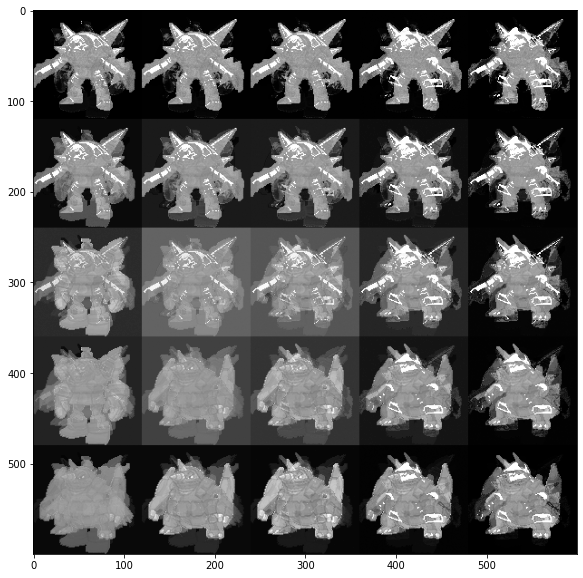

In [78]:
n = 5
figure = np.zeros((digit_size * n, digit_size * n))
# # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# # to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
#
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(16,10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
